Using the animal control incident call log, I've selected the dog species as a target, using only color, breed, and size for predictive features in attempt to predict a dangerous/bite situation, or a non-dangerous situation. I would like to think that the color, size, and breed of a dog isn't as deterministic of it's risk/lack of risk of harming others, but I will approach this with the goal of finding otherwise.

## import libraries, packages, data

### libraries, packages

In [1]:
#import
import pandas as pd
import numpy as np
# import seaborn as sns
# sns.set(style='darkgrid')
import matplotlib.pyplot as plt
# %matplotlib inline
# import pandas_profiling
# import datetime
# import re
# import pprint
# pp = pprint.PrettyPrinter(indent=4)
# from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#importing libraries & packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

Using TensorFlow backend.


### import clean data from part 1

In [3]:
# import Animal Control Incidents df
df = pd.read_csv('a_control.csv')

In [4]:
#df.info()

In [5]:
df = df[df['species']=='dog']

In [6]:
df.service_type.value_counts()

loose_stray       12511
cruelty            1957
bite_dangerous     1878
sick_inj           1368
owned              1321
trapped_animal     1042
patrol              712
school_call         172
other                93
pit                   8
snake                 4
pick_up_trap          1
Name: service_type, dtype: int64

In [7]:
df = df[['breed', 'size', 'color', 'service_type']]

In [8]:
for word in ('loose_stray', 'sick_inj', 'owned', 'trapped_animal', 'patrol', 'school_call'
            ,'other', 'pit', 'snake', 'pick_up_trap', 'cruelty'):
    df['service_type'] = df['service_type'].replace(word, 'not_bite/dang')

In [9]:
df=df.dropna()

In [10]:
# # assign target
y = df["service_type"]

#remove target from features
df.drop(columns= ['service_type'], axis=1, inplace=True)

# dummy categorical features
#col_list = list(df.select_dtypes(include=['object']).columns)
col_list = list(df.columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df, drop_first=True
                   , prefix=col_list))
X = df


In [11]:

# X_train_d and y_train_d = using original standard test train spit dad
# that way, I can try out different resampling methods
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=33)

### functions

In [12]:
# print model report
def model_report(model, cm = True): 
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))

    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))
    
    if cm :

        cv_score = np.mean(cross_val_score(model, X, y, cv=3))
        print("cross val score: {:.4}%".format(cv_score * 100))

        print("\nClassification Report:")
        print(classification_report(actuals, predictions))

        col_list = ['pred bite/dangerous', 'pred not_bite/not_dangerous']
        ind_list = ['real bite/dangerous', 'real not_bite/not_dangerous']                     
#         for x in y_test.unique():
#             col_list.append('pred_'+ x)
#             ind_list.append('real_'+x)


        print('\nConfusion matrix:'.format(accuracy_score))
        display(pd.DataFrame(confusion_matrix(y_test, predictions)
                             , columns=col_list, index=ind_list))


    else:
        pass

In [13]:
def plot_feats(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,10))
#     plt.barh(range(n_features), model.feature_importances_, align='center') 
#     plt.yticks(np.arange(n_features), (X.columns.values)) 
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(25).plot(kind='barh');
    plt.show();

In [14]:
def plot_matrix(classifier):

    disp = plot_confusion_matrix(classifier, X_test, y_test,
    #                                  display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
#     disp.ax_.set_title(title);
    plt.show();
#     np.set_printoptions(precision=2)

#     # Plot non-normalized confusion matrix
#     titles_options = [
#                       ("Normalized confusion matrix", 'true')]
#     for title, normalize in titles_options:
#         disp = plot_confusion_matrix(classifier, X_test, y_test,
#     #                                  display_labels=class_names,
#                                      cmap=plt.cm.Blues,
#                                      normalize=normalize)
#         disp.ax_.set_title(title)

# #         print(title)
# #         print(disp.confusion_matrix)

#     plt.show();

### Feature importance accoring to chi2 and ExtraTrees

In [15]:
# chi features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feats','Score']  #naming columns
print(featureScores.nlargest(25,'Score'))  #print best features


                           Feats       Score
94                    size_large  158.480621
96                    size_small   89.380895
49                breed_labrador   47.733195
95                   size_medium   45.943906
59                     breed_pit   42.571011
120               color_blue,wht   25.563041
23              breed_cane_corso   21.404374
1         breed_american_bulldog   20.259653
86                 breed_terrier   20.189800
144                color_gry,wht   19.538263
118                   color_blue   13.472050
46                   breed_hound   12.585562
9                   breed_beagle   12.057171
114              color_bk,tn,wht   11.453710
2          breed_american_eskimo   10.168795
15   breed_bourvier_des_flanders   10.168795
30               breed_coonhound   10.168795
66                  breed_rabbit   10.168795
16                   breed_boxer    9.950365
45                  breed_healer    8.755469
69               breed_retriever    7.978559
60        

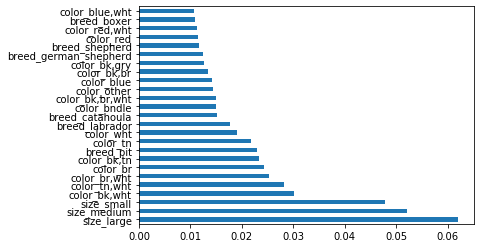

In [16]:
## extraTrees classifier feature importance
# # using extratrees to look at feature importance
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh');
plt.show();

## prep data

### resampling

Due to the imbalance of class data, it could be beneficial to resample to compensate for the missing data. Using smote to oversample, then random undersampling is a common practice in these circumstances



In [17]:
over = SMOTE(sampling_strategy='minority', random_state=3)
under = RandomUnderSampler( sampling_strategy='majority',
    random_state=3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# # transform the dataset
X_train, y_train = under.fit_resample(X_train, y_train)

In [18]:
print (y_train.value_counts())

bite_dangerous    1261
not_bite/dang     1261
Name: service_type, dtype: int64


## __modeling__

Logistic Regression basic default model

In [19]:
lr = LogisticRegression(random_state=3)
lr.fit(X_train, y_train)
 
# Predict on training set
predictions = lr.predict(X_test)
actuals = y_test

model_report(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Cross Validation Scoring:

train score: 62.13%
test score: 62.1%
cross val score: 91.04%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.13      0.59      0.22       540
 not_bite/dang       0.94      0.62      0.75      5495

      accuracy                           0.62      6035
     macro avg       0.54      0.60      0.48      6035
  weighted avg       0.87      0.62      0.70      6035


Confusion matrix:


,pred bite/dangerous,pred not_bite/not_dangerous
real bite/dangerous,316,224
real not_bite/not_dangerous,2063,3432


### decision tree

__default model__

In [20]:
# initialize and fit default decision tree
dt_model = DecisionTreeClassifier(random_state=3)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)
#actuals = y_test

model_report(dt_model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')


Cross Validation Scoring:

train score: 72.44%
test score: 52.34%
cross val score: 89.92%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.11      0.62      0.19       540
 not_bite/dang       0.93      0.51      0.66      5495

      accuracy                           0.52      6035
     macro avg       0.52      0.57      0.43      6035
  weighted avg       0.86      0.52      0.62      6035


Confusion matrix:


,pred bite/dangerous,pred not_bite/not_dangerous
real bite/dangerous,333,207
real not_bite/not_dangerous,2669,2826


#### grid searches

In [21]:
# set random search params
criterion=['gini','entropy']
max_leaf_nodes = [None]
max_features = [50,60,65,70,80]
max_depth = [5,10,15,20,25]
min_samples_split = [1,2,3,4,5]
min_samples_leaf = [6,8,10,12,15]

random_grid = {'criterion':criterion,
               'max_leaf_nodes': max_leaf_nodes,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

# random grid search
dt_random = RandomizedSearchCV(estimator = dt_model
                               , param_distributions = random_grid
                               , n_iter = 100, cv = 5, verbose=3, error_score=0
                               , scoring=('f1_macro')
                               , random_state=3, n_jobs = -1);
# fit random search model
dt_random.fit(X_train, y_train);

print('best score: {:.4}%'.format(dt_random.best_score_ * 100));
print(dt_random.best_params_);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.0s


best score: 60.08%
{'min_samples_split': 2, 'min_samples_leaf': 8, 'max_leaf_nodes': None, 'max_features': 70, 'max_depth': 20, 'criterion': 'gini'}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.0s finished


__grid search__

In [22]:
# grid search params
param_grid_dt = {'criterion': ['entropy', 'gini'],
    'max_depth': [15,16,17,18,20],
    'min_samples_split': [1,2,3,4,5],
    'min_samples_leaf': [7,8,9,10],
     'max_features':[60,62,63,65,67],
     'max_leaf_nodes':[None]
        }

# grid search
gs_dt = GridSearchCV(estimator=dt_model,param_grid=param_grid_dt,
                    error_score=0,scoring=('f1_macro'),
                    cv=5, n_jobs=-1, verbose=2)

# fitting grid search
gs_dt.fit(X_train, y_train)

# best parameters
print('Best score: {:.3}%'.format(gs_dt.best_score_ * 100))
print('params:\n', gs_dt.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 2268 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 3728 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=0,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=3, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [15, 16, 17, 18, 20],
            

Best score: 60.6%
params:
 {'criterion': 'entropy', 'max_depth': 15, 'max_features': 62, 'max_leaf_nodes': None, 'min_samples_leaf': 7, 'min_samples_split': 2}


In [23]:
# using best params to fit model
dt_gs_model = DecisionTreeClassifier(criterion='entropy',
                              max_depth=16,
                              max_features=65,
                              max_leaf_nodes= None,
                               min_samples_leaf=9,
                               min_samples_split=2
                                 )
dt_gs_model.fit(X_train, y_train)

predictions = dt_gs_model.predict(X_test)
actuals = y_test

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=16, max_features=65, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### final model

In [24]:
model_report(dt_gs_model)


Cross Validation Scoring:

train score: 63.52%
test score: 57.83%
cross val score: 91.01%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.12      0.60      0.20       540
 not_bite/dang       0.94      0.58      0.71      5495

      accuracy                           0.58      6035
     macro avg       0.53      0.59      0.46      6035
  weighted avg       0.86      0.58      0.67      6035


Confusion matrix:


,pred bite/dangerous,pred not_bite/not_dangerous
real bite/dangerous,322,218
real not_bite/not_dangerous,2327,3168


In [25]:
plot_matrix(dt_gs_model)

NameError: name 'normalize' is not defined

In [ ]:


plot_feats(dt_gs_model)

### Random Forest

---
__default model__

In [ ]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
#actuals = y_test

model_report(rf_model)

#### grid searches

___
__Random Grid Search__

The default model is overfitting. Some ways to avoid overfitting with random forests are: increasing the n_estimators, reducing max features, limiting max depth, and increasing min leaf samples can help construct a more robust fit. Being that it did perform well despite the overfitting, I decided not to go crazy playing with the parameters.

In [ ]:
# set random search params

n_estimators = [600,800,700,1000,1500]
min_weight_fraction_leaf=[0.0, 0.0001, 0.00001]
min_samples_split = [3,4,5,6,7,8]
min_samples_leaf = [1]
min_impurity_split = [0.0]
min_impurity_decrease = [0.0, 0.0001, 0.01]
max_samples = [None]
max_leaf_nodes = [None, 3,10,15,20,25,30]
max_features = ['auto', 3,5,6,8,10,50]
max_depth = [10,30,60,70,80,100,130]
criterion = ['entropy', 'gini']
bootstrap = [True, False]

# Create the random grid
random_grid = { 'n_estimators': n_estimators,
                 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'min_impurity_split': min_impurity_split,
                 'min_impurity_decrease': min_impurity_decrease,
                 'max_samples': max_samples,
                 'max_leaf_nodes': max_leaf_nodes,
                 'max_features': max_features,
                  'max_depth': max_depth,
                 'criterion': criterion,
                 'bootstrap': bootstrap
              }

# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid
                               , n_iter = 150, cv = 5, verbose=5
                               , random_state=1, scoring='f1_macro', n_jobs = -1);
# Fit the random search model
rf_random.fit(X_train, y_train);

# print best parameters
print('best score: {:.4}%'.format(rf_random.best_score_ * 100));
print(rf_random.best_params_);

___
__grid search__

In [ ]:
param_grid_rf = {
        'n_estimators': [1350,1400,1450]
         , 'min_samples_leaf': [1,2]
         , 'min_samples_split':[6,7,8]
        , 'max_samples': [None]
       , 'max_leaf_nodes':[13,14,15]
         , 'max_features': ['auto']
         , 'max_depth': [70,75,80]
         , 'criterion': [ 'entropy','gini']
         , 'bootstrap': [False]
}

# grid search
gs_rf = GridSearchCV(estimator=rf_model,param_grid=param_grid_rf
                    ,cv=5,scoring='f1_macro',refit=True,error_score=0
                    , n_jobs=-1, verbose=5)

# fitting grid search
gs_rf.fit(X_train, y_train);

# best parameters
print('best score: {:.4}%'.format(gs_rf.best_score_ * 100));
print('params:\n', gs_rf.best_params_);

#### final model

___
__best model__

In [ ]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(
                                   bootstrap= False
                                    ,criterion= 'gini'
                                    , max_depth= 75
                                   , max_features = 'auto'
                                   , max_leaf_nodes = 14
                                   , max_samples = None
                                    , min_samples_leaf = 1
                                   , min_samples_split = 7
                                    , n_estimators = 1400
                                    );
rf_gs_model.fit(X_train, y_train);

predictions = rf_gs_model.predict(X_test);

# new model report
model_report(rf_gs_model)

In [ ]:
plot_matrix(rf_gs_model)

In [ ]:
plot_feats(rf_gs_model)

### XGBoost

In [26]:
# initiate model
xgb_model = XGBClassifier(random_state=3)
xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)
# actuals = y_test

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [27]:
model_report(xgb_model)


Cross Validation Scoring:

train score: 62.45%
test score: 64.62%
cross val score: 91.05%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.14      0.55      0.22       540
 not_bite/dang       0.94      0.66      0.77      5495

      accuracy                           0.65      6035
     macro avg       0.54      0.60      0.50      6035
  weighted avg       0.87      0.65      0.72      6035


Confusion matrix:


,pred bite/dangerous,pred not_bite/not_dangerous
real bite/dangerous,299,241
real not_bite/not_dangerous,1894,3601


#### grid searches

In [ ]:
#set random search params
learning_rate=[.009,.01,.25,.2,.15 ,.1]
max_depth = [2,3,4,5,6,7,8,9]
min_child_weight = [.8,1,1.5,1.9,2]
n_estimators = [70,80,90,100, 110,150,200,250]
min_weight_fraction_leaf = [0,0.0001,0.005, 0.01, 1]
gamma = [0.0, 0.001,0.005, 0.01]

random_grid = {
               'learning_rate':learning_rate
               ,'max_depth': max_depth
               ,'min_child_weight':min_child_weight
            ,'n_estimators': n_estimators
                , 'gamma': gamma
              }

# searching random params
xgb_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = random_grid
                               , n_iter = 150, cv = 5, verbose=5
                               ,scoring='f1_macro', random_state=3, n_jobs = -1)
# fit random search model
xgb_random.fit(X_train, y_train)
print('best score: {:.4}%'.format(xgb_random.best_score_ * 100));
print(xgb_random.best_params_);

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 42.8min


In [ ]:
param_grid_xgb = [
    {
         'gamma':[0.0009, 0.001, 0.0011],
        'min_child_weight': [1,2,3,4],
    'learning_rate': [0.008,0.009,0.1],
    'n_estimators': [175,200,225],
    'max_depth': [7,8,9]
    }
]

# Construct Grid Search
gs_xgb = GridSearchCV(estimator=xgb_model,
                    param_grid=param_grid_xgb,
                    scoring='f1_macro',
                    cv=3, n_jobs=-1, verbose=10)

# Fit using grid search
gs_xgb.fit(X, y)

# Best accuracy and parameters
print('best score: {:.3}%'.format(gs_xgb.best_score_ * 100))
print('params:\n', gs_xgb.best_params_);

#### final model

In [ ]:
# fit using best params
xgb_gs_model = XGBClassifier(learning_rate=0.008,
                           #  max_depth=3,
                             min_child_weight=.9)
                          #   n_estimators=90)
xgb_gs_model.fit(X_train, y_train)

predictions = xgb_gs_model.predict(X_test)

model_report(xgb_gs_model)

### AdaBoost

In [ ]:
#initialize and fit default model
ada_model = AdaBoostClassifier(random_state=3)
ada_model.fit(X_train, y_train)

predictions = ada_model.predict(X_test)
# actuals = y_test

___
__Default Model__

In [ ]:
model_report(ada_model)

#### grid searches

__Random Grid Search__

In [ ]:
#set random search params
learning_rate= [.09,.1,1,1.5,2]

n_estimators = [50,100,200,500]

random_grid = {'learning_rate':learning_rate,
               'n_estimators': n_estimators
              }

#random grid search
ada_random = RandomizedSearchCV(estimator = ada_model
                               , param_distributions = random_grid
                               , n_iter = 10, cv = 5, verbose=7, scoring='f1_macro'
                               , random_state=3, n_jobs = -1)
# Fit the random search model
ada_random.fit(X_train, y_train)

ada_random.best_params_

___
__grid search__

In [ ]:
#grid search params and fitting grid search
param_grid_ada = [
    {'n_estimators': [195,197,200,202,205],
    'learning_rate': [0.08, 0.09, 0.1, 0.11,0.12]}
]

# Construct Grid Search
gs_ada = GridSearchCV(estimator=ada_model,
                    param_grid=param_grid_ada,
                    scoring='f1_macro',
                    cv=5, n_jobs=-1, verbose=2)

# Fit using grid search
gs_ada.fit(X_train, y_train);

# Best accuracy and parameters
print('best score: {:.4}%'.format(gs_ada.best_score_ * 100))
print('params:\n', gs_ada.best_params_)

In [ ]:
# fit best params
ada_gs_model = AdaBoostClassifier(n_estimators=200,
                                   learning_rate=.1)
ada_gs_model.fit(X_train, y_train);

predictions = ada_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
model_report(ada_gs_model)

### gradient boost

In [ ]:
#initialize and fit gradient boost
gbt_model = GradientBoostingClassifier(random_state=3)
gbt_model.fit(X_train, y_train)

predictions = gbt_model.predict(X_test)
# actuals = y_test

__default model__

In [ ]:
#baseline model report
model_report(gbt_model)

#### grid searches

__random grid search__

In [ ]:
# setting parameters for random search
learning_rate=[.2,.1, .09, 0.05, 0.01]
loss = ['deviance', 'exponential']
max_depth = [None,2,3,4,5,6] 
n_estimators = [10,30,50,70,100,130]
min_samples_split = [1,2,3,4,6]
min_samples_leaf = [1,2,3,5,6,7,8, 10, 12,15]
min_weight_fraction_leaf = [0,0.0001, 0.001, 0.00001]

random_grid = {'learning_rate':learning_rate,
              'loss': loss,
               'max_depth': max_depth,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               ,'min_weight_fraction_leaf': min_weight_fraction_leaf
               }

#searching random params
gbt_random = RandomizedSearchCV(estimator = gbt_model, param_distributions = random_grid
                               , n_iter = 100, cv = 5, verbose=3, scoring='f1_macro'
                               , random_state=3, n_jobs = -1)
# fit random search model
gbt_random.fit(X_train, y_train)

print('best score: {:.4}%'.format(gbt_random.best_score_ * 100));
print(gbt_random.best_params_)

__grid search__

In [ ]:
# grid search params and run search
param_grid_gbt = [
    {'n_estimators': [11,12],
     'min_weight_fraction_leaf':[0, 0.001],
    'learning_rate': [0.09,0.1],
    'min_samples_split': [4,5],
    'min_samples_leaf': [1],
    'max_depth': [5,6,7],
     'loss':['deviance', 'exponential']
    }]
# grid search
gs_gbt = GridSearchCV(estimator=gbt_model,
                    param_grid=param_grid_gbt,scoring='f1_macro',
                    cv=5, n_jobs=-1, verbose=2)

# fit grid search
gs_gbt.fit(X_train, y_train)

# best params
print('best score: {:.4}%'.format(gs_gbt.best_score_ * 100))
print('params:\n', gs_gbt.best_params_)

In [ ]:
# fitting best params
gbt_gs_model = GradientBoostingClassifier(learning_rate=0.09,
                                          loss= 'deviance',
                                         max_depth=6,
                                         min_samples_leaf=1,
                                         min_samples_split=4,
                                         min_weight_fraction_leaf=0.001,
                                         n_estimators=11)
gbt_gs_model.fit(X_train, y_train)

predictions = gbt_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
# new model report
model_report(gbt_gs_model)

### SVM

In [ ]:
svm_model = svm.SVC(random_state=3)
svm_model.fit(X_train, y_train)

predictions = svm_model.predict(X_test)
# actuals = y_test

___
__default model__

In [ ]:
model_report(svm_model)

#### grid searches

___
__random grid search__

In [ ]:
# set random search params
clf_C = [0.09,0.1,1.0, 1.01]
clf_gamma = [0.005,0.001,0.01, 0.1, 0.11, 0.15]
clf_kernel = ['rbf', 'linear']

random_grid = {
               'C': clf_C,
               'gamma': clf_gamma,
               'kernel': clf_kernel
               }

# fit and search random param combinations
svm_random = RandomizedSearchCV(estimator = svm_model, param_distributions = random_grid
                               , n_iter = 50 , cv = 5, verbose=10
                               , scoring='f1_macro', random_state=3, n_jobs = -1)
# Fit the random search model
svm_random.fit(X_train, y_train)

print('best score: {:.4}%'.format(svm_random.best_score_ * 100));
print(svm_random.best_params_)

___
__grid search__

In [ ]:
# Set grid search params
param_grid_svm = [
  {'C': [0.9,1.0, 1.1], 'gamma': [0.002, 0.004, 0.005, 0.006, 0.008]
   , 'kernel': ['rbf', 'linear']
  }]
 
# Construct grid search
gs_svm = GridSearchCV(estimator=svm_model,
            param_grid=param_grid_svm, scoring='f1_macro'
            , cv=5, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('best score: {:.4}%'.format(gs_svm.best_score_ * 100));
print('\nBest params:\n', gs_svm.best_params_)

In [ ]:
svm_gs_model = svm.SVC(C=0.5
                       ,gamma=0.002
                        ,kernel='linear'
                             )
svm_gs_model.fit(X_train, y_train)

predictions = svm_gs_model.predict(X_test)

#### final model

___
__best model__

In [ ]:
model_report(svm_gs_model)